<h1> Battle of Neighborhoods- Opening an arcade in New York </h1>

<h2> Context/Introduction

 </h2>

In this notebook, I will be using New York borough and neighborhood data acquired from an earlier lab in order to answer a few fairly simple questions: Where should I open an arcade in New York? If I were in New York, which neighborhood should I visit to get the most out of my trip? Finally, there are many different types of arcades nowadays. What type should I be opening?

Arcades are a dying breed, and as someone who enjoys gaming, it's been a sad sight seeing them go. I'm hoping this might help someone understand what the arcade scene is like in New York, and make effective decisions about where they might want to open one, and where they might want to visit to get an idea of what it's like.

In [1]:
#Importing stuff. Mostly from the New York and Toronto labs
!pip install lxml html5lib beautifulsoup4

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import requests

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

print("Importing complete")

     |████████████████████████████████| 122kB 17.8MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py36h5fab9bb_0         141 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         375 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following package

In [39]:
#As stated earlier, I worked with a set of New York geodata before, and knowing its accuracy, I feel fairly safe using it again
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json

In [2]:
#Now let's load the JSON into something we can use
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
#Let's make sure it downloaded correctly
ny_features = newyork_data['features']

ny_features[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [4]:
#Let's load the dataframe

neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

for data in ny_features:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
neighborhoods.shape[0]

306

Now let's prep the FourSquare API in order to grab our arcade venues from the various neighborhoods. I will be using a slightly modified function from a previous lab in order to do so.

In [9]:
CLIENT_ID = 'LVW0UKKSZK0B45ASSANGDTANEN02NDKF2K23LSI25QPHJKGX' 
CLIENT_SECRET = 'DMTOIBNWYUV3GYL0YIDVL2OXNUJYBNLEI3FKIN0EC4X5XMKF'
CATEGORY_ID = '4bf58dd8d48988d1e1931735' #This category ID is provided by FourSquare, and corresponds to arcade venues specifically
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(boroughs, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for borough, name, lat, lng in zip(boroughs, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORY_ID)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
arcade_venues = getNearbyVenues(boroughs=neighborhoods['Borough'],
                                   names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [11]:
arcade_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Baychester,40.866858,-73.835798,Chuck E. Cheese,4b6f201bf964a520b8de2ce3,40.863216,-73.833268,Arcade
1,Bronx,West Farms,40.839475,-73.877745,River Park,4b006a75f964a520f43d22e3,40.843062,-73.877520,Arcade
2,Brooklyn,Greenpoint,40.730201,-73.954241,Sunshine Laundry & Pinball Emporium,4c018f2e716bc9b6c319bc55,40.729318,-73.953564,Laundry Service
3,Brooklyn,Greenpoint,40.730201,-73.954241,Black Rabbit,46869096f964a52048481fe3,40.730057,-73.956588,Bar
4,Brooklyn,Greenpoint,40.730201,-73.954241,Farnum & Son Interactive,4d61a796ef378cfac5a68da6,40.733700,-73.953003,Arcade


In [34]:
arcade_venues.shape[0]

66

Notice now, that even though we used the Category ID to only pull arcades, that we're also getting things classified as Laundry Service or Bar. What this means generally, is that it is a type of business that is COMBINED with an arcade! How many unique categories, then, do we have, and how many are purely arcades?

In [12]:
#Let's just import a bunch of graphing-related libraries, they might be useful down the line

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

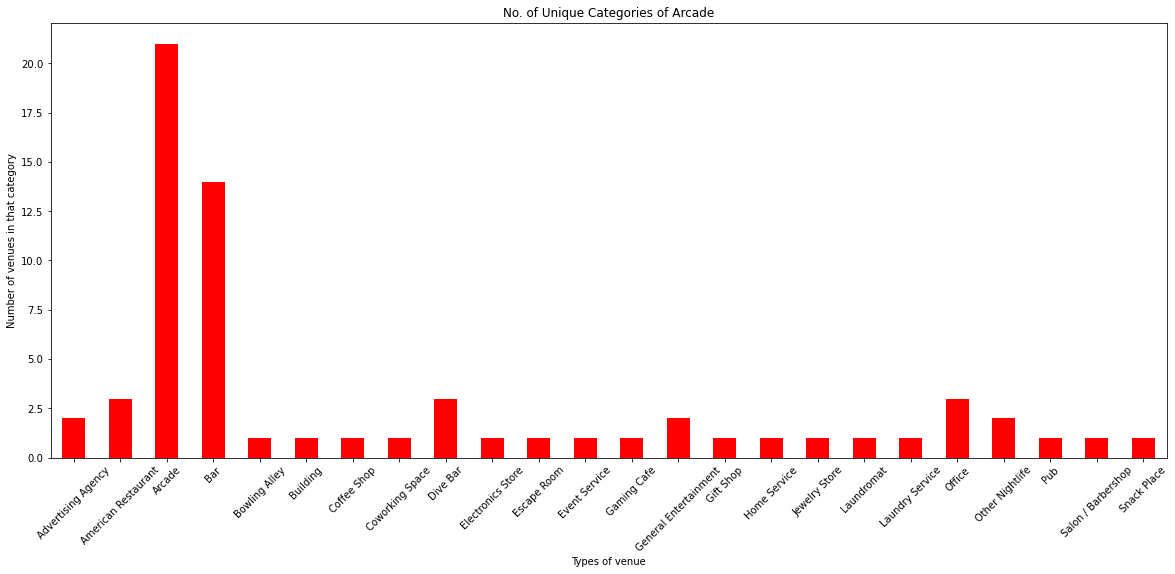

In [13]:
arcade_venues.groupby('Venue Category')['Venue Category'].count().plot.bar(figsize=(20, 8), color= 'red')
plt.title('No. of Unique Categories of Arcade')
plt.xlabel('Types of venue')
plt.ylabel('Number of venues in that category')
plt.xticks(rotation = 45)
plt.show()

So, pure arcades are still the most prevalent, but after that, we see a lot of bars, or "Barcades," as they're known. Let's see where all these arcades are now

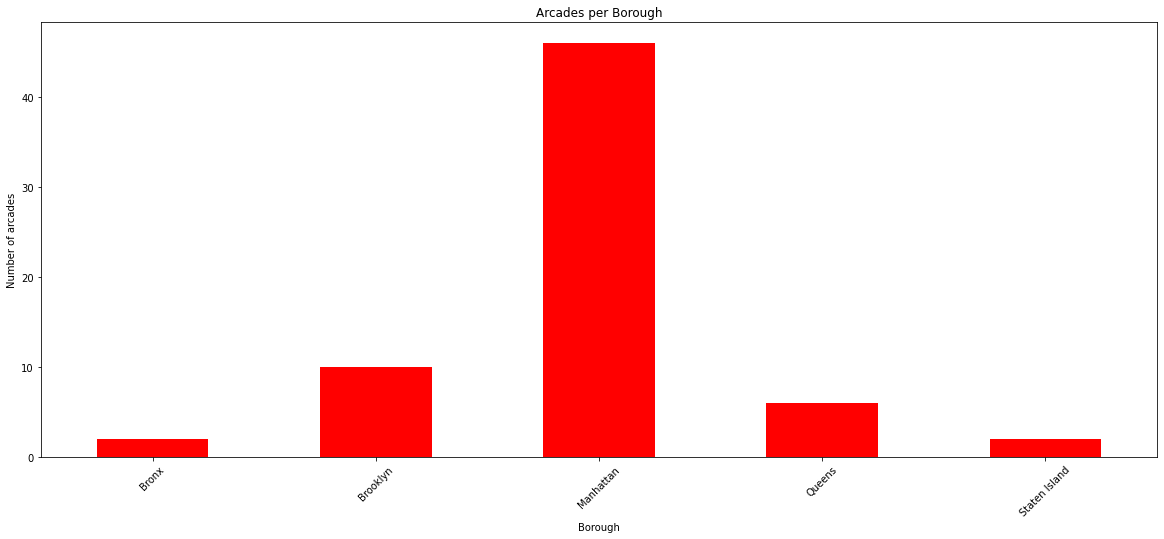

In [14]:
arcade_venues.groupby('Borough')['Venue'].count().plot.bar(figsize=(20, 8), color= 'red')
plt.title('Arcades per Borough')
plt.xlabel('Borough')
plt.ylabel('Number of arcades')
plt.xticks(rotation = 45)
plt.show()

Well, that seems pretty clear. Now let's see which neighborhoods in Manhattan have these arcades in them.

In [15]:
manhattan_arcades = arcade_venues[arcade_venues['Borough'] == 'Manhattan'].reset_index(drop = True)
manhattan_arcades.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Manhattan,Chinatown,40.715618,-73.994279,Chinatown Fair Video Arcade,5053d510e4b0719d67706d96,40.713967,-73.998716,Arcade
1,Manhattan,Central Harlem,40.815976,-73.943211,Harlem Arcade,4c649a46e0c4be9aca168658,40.816290,-73.941351,Arcade
2,Manhattan,Upper West Side,40.787658,-73.977059,82nd Street Grocery,4b54ae6df964a520c8c627e3,40.785089,-73.976971,Snack Place
3,Manhattan,Upper West Side,40.787658,-73.977059,Jake's Dilemma,3fd66200f964a52042e81ee3,40.784268,-73.977567,Dive Bar
4,Manhattan,Midtown,40.754691,-73.981669,Arcade Coffee,4c6e835fe6b7b1f77db2ac8e,40.757669,-73.979899,Coffee Shop


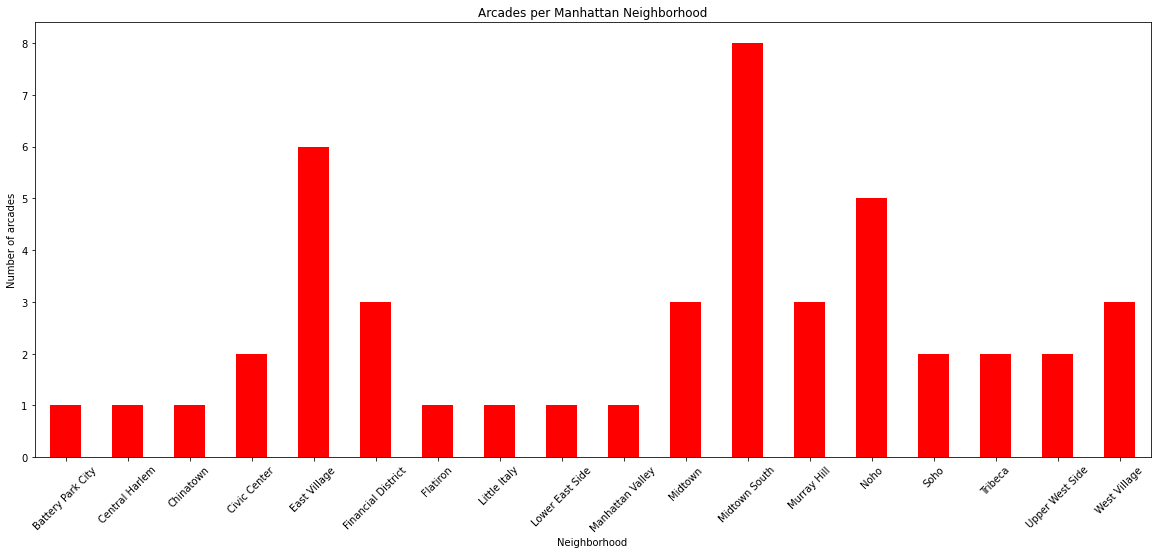

In [16]:
manhattan_arcades.groupby('Neighborhood')['Venue'].count().plot.bar(figsize=(20, 8), color= 'red')
plt.title('Arcades per Manhattan Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of arcades')
plt.xticks(rotation = 45)
plt.show()

Looks like most of them are in Midtown South, which has 8 of them. East Village is next with 6. Now let's put on a map where in Manhattan these places actually are.

In [17]:
venues_map = folium.Map(location=[40.7831, -73.9712], zoom_start=10)

markers_colors = []
for lat, lon, poi in zip(manhattan_arcades['Venue Latitude'], manhattan_arcades['Venue Longitude'], manhattan_arcades['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(venues_map)
       
venues_map

So it looks like our arcades are semi-evenly spread, with a tendency to be in the southern parts of Manhattan. I should mention that we've been focusing on Manhattan at the end here simply because it has the most venues. Let's now look at where everything else is, just for fun.

In [18]:
venues_map2 = folium.Map(location=[40.7831, -73.9712], zoom_start=10)

markers_colors = []
for lat, lon, poi in zip(arcade_venues['Venue Latitude'], arcade_venues['Venue Longitude'], arcade_venues['Venue']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(venues_map2)
       
venues_map2

Well. That's all pretty spread out, isn't it? Now, let's make some clusters according to the specific type of arcades present in each neighborhood.

In [19]:
from sklearn.cluster import KMeans


arcade_onehot = pd.get_dummies(arcade_venues[['Venue Category']], prefix="", prefix_sep="")


arcade_onehot['Neighborhood'] = arcade_venues['Neighborhood'] 

cols = list(arcade_onehot)

cols.insert(0, cols.pop(cols.index('Neighborhood')))

arcade_onehot = arcade_onehot.loc[:, cols]
arcade_onehot

,Neighborhood,Advertising Agency,American Restaurant,Arcade,Bar,Bowling Alley,Building,Coffee Shop,Coworking Space,Dive Bar,...,Gift Shop,Home Service,Jewelry Store,Laundromat,Laundry Service,Office,Other Nightlife,Pub,Salon / Barbershop,Snack Place
0,Baychester,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,West Farms,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Greenpoint,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Greenpoint,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Greenpoint,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Elm Park,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,Utopia,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,Astoria Heights,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,Flatiron,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


You probably know the drill. Let's group this up by neighborhood and figure out the means of the frequency of each category

In [20]:
arcade_grouped = arcade_onehot.groupby('Neighborhood').mean().reset_index()
arcade_grouped

,Neighborhood,Advertising Agency,American Restaurant,Arcade,Bar,Bowling Alley,Building,Coffee Shop,Coworking Space,Dive Bar,...,Gift Shop,Home Service,Jewelry Store,Laundromat,Laundry Service,Office,Other Nightlife,Pub,Salon / Barbershop,Snack Place
0,Astoria Heights,0.0,0.000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
1,Battery Park City,0.0,0.000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
2,Baychester,0.0,0.000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
3,Bedford Stuyvesant,0.0,0.000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
4,Boerum Hill,0.0,0.000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
5,Central Harlem,0.0,0.000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
6,Chinatown,0.0,0.000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
7,Civic Center,0.0,0.000,0.500000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
8,Downtown,0.0,0.000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
9,East Village,0.0,0.000,0.166667,0.500000,0.0,0.000000,0.000000,0.000000,0.333333,...,0.000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0


Now, let's get the top five most popular types of arcade in each neighborhood! This might help us with some insight as to what type of arcade to open and where. Note that a fair few of these neighborhoods only have one of these types of venues, so there won't even be a top 5 for some.

In [21]:
num_top_venues = 5

for hood in arcade_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = arcade_grouped[arcade_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Astoria Heights----
                   venue  freq
0          Bowling Alley   1.0
1     Advertising Agency   0.0
2  General Entertainment   0.0
3     Salon / Barbershop   0.0
4                    Pub   0.0


----Battery Park City----
                   venue  freq
0                 Arcade   1.0
1     Advertising Agency   0.0
2  General Entertainment   0.0
3     Salon / Barbershop   0.0
4                    Pub   0.0


----Baychester----
                   venue  freq
0                 Arcade   1.0
1     Advertising Agency   0.0
2  General Entertainment   0.0
3     Salon / Barbershop   0.0
4                    Pub   0.0


----Bedford Stuyvesant----
                   venue  freq
0                    Bar   1.0
1     Advertising Agency   0.0
2  General Entertainment   0.0
3     Salon / Barbershop   0.0
4                    Pub   0.0


----Boerum Hill----
                   venue  freq
0                 Arcade   1.0
1     Advertising Agency   0.0
2  General Entertainment   0.0
3     Sa

Now let's sort this into a pandas dataframe. In past labs, we listed the top 10 venues into a dataframe, however, seeing as we're already having trouble getting a top 5 due to the lack of arcades, we're going to simply stick with 5.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_arcades_sorted = pd.DataFrame(columns=columns)
neighborhoods_arcades_sorted['Neighborhood'] = arcade_grouped['Neighborhood']

for ind in np.arange(arcade_grouped.shape[0]):
    neighborhoods_arcades_sorted.iloc[ind, 1:] = return_most_common_venues(arcade_grouped.iloc[ind, :], num_top_venues)

neighborhoods_arcades_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Astoria Heights,Bowling Alley,Snack Place,Salon / Barbershop,American Restaurant,Arcade
1,Battery Park City,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
2,Baychester,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
3,Bedford Stuyvesant,Bar,Snack Place,Salon / Barbershop,American Restaurant,Arcade
4,Boerum Hill,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
5,Central Harlem,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
6,Chinatown,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
7,Civic Center,Arcade,Bar,Snack Place,Salon / Barbershop,American Restaurant
8,Downtown,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
9,East Village,Bar,Dive Bar,Arcade,Snack Place,Salon / Barbershop


Here, the problem with the data becomes more obvious. In places where there's only one arcade, the default is to set the second value to Snack Place, even though a snack place arcade may not exist there.

In [23]:
#Let's stick to five for our number of clusters.
kclusters = 5

arcade_grouped_clustering = arcade_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(arcade_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 2, 1, 2, 2, 2, 1, 2, 1], dtype=int32)

In [26]:
neighborhoods_arcades_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

arcades_merged = arcade_venues


arcades_merged = arcades_merged.join(neighborhoods_arcades_sorted.set_index('Neighborhood'), on='Neighborhood')

arcades_merged = arcades_merged.drop(['Venue', 'Venue ID', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis= 1)

arcades_merged = arcades_merged.drop_duplicates(subset = 'Neighborhood', keep = 'first').reset_index(drop = True)

arcades_merged.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Baychester,40.866858,-73.835798,2,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
1,Bronx,West Farms,40.839475,-73.877745,2,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
2,Brooklyn,Greenpoint,40.730201,-73.954241,1,Bar,Arcade,Laundry Service,Snack Place,Escape Room
3,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,1,Bar,Snack Place,Salon / Barbershop,American Restaurant,Arcade
4,Brooklyn,Gowanus,40.673931,-73.994441,2,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar


In [27]:
map_clusters = folium.Map(location=[40.7128, -74.0060], zoom_start=10)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(arcades_merged['Neighborhood Latitude'], arcades_merged['Neighborhood Longitude'], arcades_merged['Neighborhood'], arcades_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Well, there's definitely a method here. Let's take a look at each cluster

In [28]:
arcades_merged.loc[arcades_merged['Cluster Labels'] == 0, arcades_merged.columns[[1] + list(range(5, arcades_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,Upper West Side,Snack Place,Dive Bar,Salon / Barbershop,American Restaurant,Arcade
11,Midtown,Jewelry Store,Coffee Shop,Salon / Barbershop,Snack Place,Escape Room
12,Murray Hill,Arcade,Building,General Entertainment,Snack Place,Escape Room
27,Midtown South,Office,Event Service,Electronics Store,American Restaurant,Bar
30,Astoria Heights,Bowling Alley,Snack Place,Salon / Barbershop,American Restaurant,Arcade
31,Flatiron,Escape Room,Snack Place,Salon / Barbershop,American Restaurant,Arcade
32,Middle Village,Home Service,Snack Place,Escape Room,American Restaurant,Arcade


Midtown South has the most variety and the most number of arcade venues, and in fact most of these places save for Astoria Heights, Flatiron, and Middle Village seem to have a decent variety when it comes to arcade venues. This seems to simply be a variety cluster

In [29]:
arcades_merged.loc[arcades_merged['Cluster Labels'] == 1, arcades_merged.columns[[1] + list(range(5, arcades_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Greenpoint,Bar,Arcade,Laundry Service,Snack Place,Escape Room
3,Bedford Stuyvesant,Bar,Snack Place,Salon / Barbershop,American Restaurant,Arcade
7,East Williamsburg,Office,Bar,Snack Place,Escape Room,American Restaurant
13,East Village,Bar,Dive Bar,Arcade,Snack Place,Salon / Barbershop
18,West Village,Bar,Pub,Snack Place,Escape Room,American Restaurant
21,Financial District,Bar,Laundromat,Coworking Space,Snack Place,Escape Room
25,Noho,Arcade,Bar,Gaming Cafe,Snack Place,Escape Room
26,Civic Center,Arcade,Bar,Snack Place,Salon / Barbershop,American Restaurant


This cluster's rather interesting. It seems to be where most of our "Barcades" are featured.

In [30]:
arcades_merged.loc[arcades_merged['Cluster Labels'] == 2, arcades_merged.columns[[1] + list(range(5, arcades_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Baychester,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
1,West Farms,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
4,Gowanus,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
5,Downtown,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
6,Boerum Hill,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
8,Chinatown,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
9,Central Harlem,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
14,Lower East Side,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
19,Manhattan Valley,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar
20,Battery Park City,Arcade,Snack Place,Salon / Barbershop,American Restaurant,Bar


The common theme with this cluster is that the only thing in these neighborhoods is one arcade each! If we look to our earlier neighborhood sorting, we see that each of these places has a 1.0 value for simple arcades, with zeroes in everything else.

In [31]:
arcades_merged.loc[arcades_merged['Cluster Labels'] == 3, arcades_merged.columns[[1] + list(range(5, arcades_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
15,Tribeca,Advertising Agency,American Restaurant,Salon / Barbershop,Arcade,Bar
22,Howard Beach,American Restaurant,Snack Place,Salon / Barbershop,Arcade,Bar


American Restaurant/Arcades seem to be the determining factor for this cluster.

In [32]:
arcades_merged.loc[arcades_merged['Cluster Labels'] == 4, arcades_merged.columns[[1] + list(range(5, arcades_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,Little Italy,Other Nightlife,Snack Place,Escape Room,American Restaurant,Arcade
17,Soho,Advertising Agency,Other Nightlife,Escape Room,American Restaurant,Arcade


Other Nightlife Arcade combos were the determining factor for this cluster

<h2> Conclusion </h2>

Let's reiterate the questions we set out to answer at the beginning of this project:
* Where should I open an arcade in New York? 
* What type of arcade should I open?
* If I were in New York, which neighborhood should I visit to get the most out of my trip?

The answer to the first is a bit tricky. The arcade scene is alive and well in Manhattan, but that also means more competition. The difference in the amount of arcades between Manhattan and the other borough is quite staggering, however, and so I might personally recommend opening one in Manhattan, specifically, however, East Village, simply to avoid the competition between the 8 arcades in Midtown South. You want to open in a place where arcades are still alive, but you don't want to be smothered.

So now that we've established that you may want to consider opening some type of arcade in East Village, you can see by our cluster data that East Village's most common venues are bars and barcades. It might be a good idea to simply open a pure arcade or some other type of combination arcade not yet featured in the area in order to stand out.

Finally, if you were in a single neighborhood in New York and wanted to visit the most places, you'll want to go to Midtown South in Manhattan. It simply has the most arcades and the most variety.